In [47]:

import pprint
import random
from datetime import datetime, timedelta
import string
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import requests
from colorspacious import cspace_converter
from collections import OrderedDict

In [48]:
## Get state abbrevations

In [49]:
abbrevdf = pd.read_json('state_abbreviations.json')
states = abbrevdf['Code'].to_numpy()
print(states)

['AL' 'AK' 'AZ' 'AR' 'CA' 'CO' 'CT' 'DE' 'DC' 'FL' 'GA' 'HI' 'ID' 'IL'
 'IN' 'IA' 'KS' 'KY' 'LA' 'ME' 'MD' 'MA' 'MI' 'MN' 'MS' 'MO' 'MT' 'NE'
 'NV' 'NH' 'NJ' 'NM' 'NY' 'NC' 'ND' 'OH' 'OK' 'OR' 'PA' 'RI' 'SC' 'SD'
 'TN' 'TX' 'UT' 'VT' 'VA' 'WA' 'WV' 'WI' 'WY']


In [50]:
## Get covid 19 stats for US and states

In [51]:
#states = ['AL','GA','FL','TN','LA','CA','NY','WA']
response = requests.request("GET",'https://api.covidtracking.com/v1/us/daily.json')
usdf = pd.read_json(response.text)
usdf['date'] = pd.to_datetime(usdf['date'], format='%Y%m%d')

df = pd.DataFrame()
for state in states:
    url='https://api.covidtracking.com/v1/states/{s}/daily.json'.format(s = state.lower())
    response = requests.request("GET", url)
    statedf = pd.read_json(response.text)
    statedf['date'] = pd.to_datetime(statedf['date'], format='%Y%m%d')
    df = pd.concat([df,statedf])

## Get population data for states

In [52]:
usdf['POPESTIMATE2019'] = 330183381
abbrevdf = pd.read_json('state_abbreviations.json')
popdf = pd.read_csv("scprc-est2019-18+pop-res.csv")
popdf.rename(columns={'NAME': 'State'}, inplace=True)
popdf = popdf.join(abbrevdf.set_index('State'), on='State')
df = df.join(popdf.set_index('Code'), on='state',lsuffix='',rsuffix='pop_')
df.head()

,date,state,positive,negative,pending,hospitalizedCurrently,hospitalizedCumulative,inIcuCurrently,inIcuCumulative,onVentilatorCurrently,...,grade,SUMLEV,REGION,DIVISION,STATE,State,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS,Abbrev
0,2020-08-30,AL,125235.0,855827.0,NaN,969.0,14267.0,NaN,1467.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
1,2020-08-29,AL,123889.0,851929.0,NaN,986.0,14267.0,NaN,1459.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
2,2020-08-28,AL,122185.0,842678.0,NaN,1002.0,14267.0,NaN,1450.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
3,2020-08-27,AL,121023.0,835786.0,NaN,1052.0,14005.0,NaN,1430.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.
4,2020-08-26,AL,119254.0,824431.0,NaN,1077.0,14005.0,NaN,1412.0,NaN,...,,40,3,6,1,Alabama,4903185,3814879,77.8,Ala.


In [53]:
df['popPositiveIncrease'] = df['positiveIncrease'] / df['POPESTIMATE2019'] * 1000000
usdf['popPositiveIncrease'] = usdf['positiveIncrease'] / usdf['POPESTIMATE2019'] * 1000000
usdf['7dayaverage'] = usdf['popPositiveIncrease'].rolling(window=7,min_periods=3).mean()

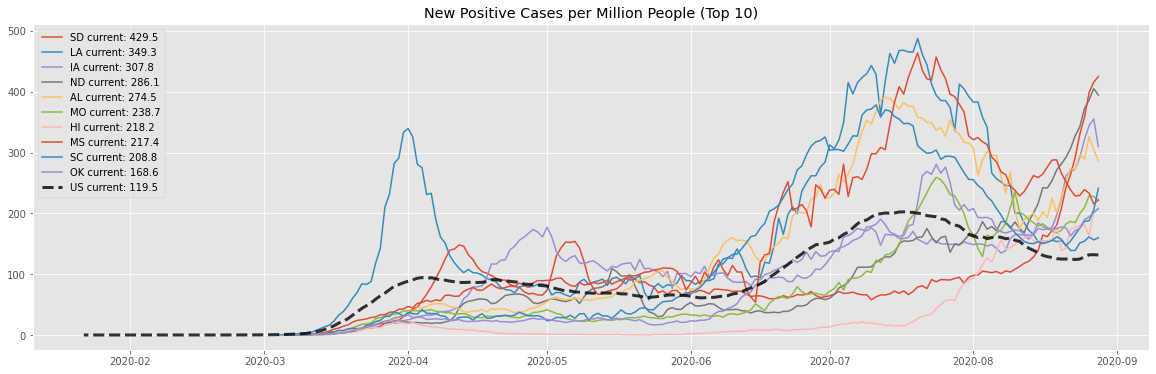

In [54]:

plt.style.use('ggplot')
plots = []
labels = []
plt.rcParams["figure.figsize"] = (20,6)
# Get ordered list of states by current popPositiveIncrease
top_states = df.sort_values(by='date').drop_duplicates(subset=['state'], keep='last').sort_values(by='popPositiveIncrease',ascending=False)
for state in top_states['state'].head(10):
    statedf = df[df['state'] == state]
    plot, = plt.plot(statedf['date'],statedf['popPositiveIncrease'].rolling(window=7,min_periods=3).mean(),label=state)
    plots.append(plot)
    currentIncrease = statedf.sort_values(by='date').iloc[-1,:].popPositiveIncrease
    labels.append("{} current: {:.1f}".format(state,currentIncrease))
plot, = plt.plot(usdf['date'],usdf['7dayaverage'],label='US',linestyle='--',linewidth=3,color='black',alpha=0.8)
plots.append(plot)
currentIncrease = usdf.sort_values(by='date').iloc[-1,:].popPositiveIncrease
labels.append("{} current: {:.1f}".format('US',currentIncrease))
plt.legend(handles=plots, labels=labels,loc='upper left')
plt.title('New Positive Cases per Million People (Top 10)')
plt.show()